Extracted 134689 patches
Epoch 1, Loss: nan
Epoch 2, Loss: nan
Epoch 3, Loss: nan
Epoch 4, Loss: nan
Epoch 5, Loss: nan


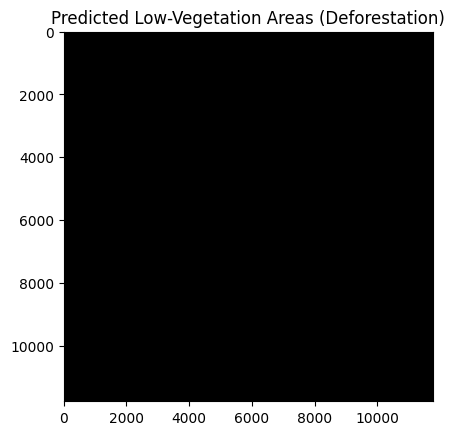

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Load TIF
def load_tif(tif_path):
    with rasterio.open(tif_path) as src:
        img = src.read()  # (bands, H, W)
        profile = src.profile
    return img.astype(np.float32), profile

# NDVI Calculation
def compute_ndvi(img):
    red = img[2]
    nir = img[3]
    ndvi = (nir - red) / (nir + red + 1e-5)
    return np.clip(ndvi, -1, 1)

# Low Vegetation Mask
def get_low_ndvi_mask(ndvi, threshold=0.3):
    return (ndvi < threshold).astype(np.uint8)

# Patch Extraction
def extract_patches(image, mask, patch_size=32, stride=32):
    H, W = mask.shape
    patches, labels = [], []
    for i in range(0, H - patch_size, stride):
        for j in range(0, W - patch_size, stride):
            patch = image[:, i:i+patch_size, j:j+patch_size]
            label_patch = mask[i:i+patch_size, j:j+patch_size]
            if patch.shape[1:] == (patch_size, patch_size):
                patches.append(patch)
                labels.append(1 if np.mean(label_patch) > 0.3 else 0)
    return np.array(patches), np.array(labels)

# Multiscale CNN
class MultiscaleCNN(nn.Module):
    def __init__(self, in_channels=4):
        super(MultiscaleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(in_channels, 32, 5, padding=2)
        self.conv5 = nn.Conv2d(in_channels, 32, 7, padding=3)
        self.final = nn.Conv2d(96, 2, 1)

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x3 = F.relu(self.conv3(x))
        x5 = F.relu(self.conv5(x))
        x_cat = torch.cat([x1, x3, x5], dim=1)
        x_out = self.final(x_cat)
        return F.log_softmax(x_out, dim=1)

# Save prediction mask
def save_mask(mask, profile, output_path):
    profile.update(dtype=rasterio.uint8, count=1)
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(mask.astype(np.uint8), 1)

# ======== PIPELINE ========
tif_path = r"C:\Users\sagni\Downloads\Deforestation Detection\Western_Ghats_After_2022-0000000000-0000011776.tif"
img, profile = load_tif(tif_path)
ndvi = compute_ndvi(img)
low_mask = get_low_ndvi_mask(ndvi)

patches, labels = extract_patches(img, low_mask)
print(f"Extracted {len(patches)} patches")

# Prepare data
X = torch.tensor(patches, dtype=torch.float32)
y = torch.tensor(labels, dtype=torch.long)
X = X / X.max()  # Normalize
y_onehot = y

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32)

# Train model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiscaleCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.NLLLoss()

for epoch in range(5):
    model.train()
    total_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        out = model(xb).mean(dim=[2, 3])  # global average pooling
        loss = loss_fn(out, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# Predict on full image
model.eval()
H, W = low_mask.shape
pred_mask = np.zeros((H, W), dtype=np.uint8)
stride = 32
patch_size = 32

with torch.no_grad():
    for i in range(0, H - patch_size, stride):
        for j in range(0, W - patch_size, stride):
            patch = img[:, i:i+patch_size, j:j+patch_size]
            if patch.shape[1:] == (patch_size, patch_size):
                x = torch.tensor(patch[None, :, :, :], dtype=torch.float32).to(device)
                x = x / x.max()
                pred = model(x)
                label = torch.argmax(pred.mean(dim=[2, 3]), dim=1).item()
                pred_mask[i:i+patch_size, j:j+patch_size] = label

# Save and show mask
save_path = "deforestation_mask.tif"
save_mask(pred_mask, profile, save_path)

plt.imshow(pred_mask, cmap='gray')
plt.title("Predicted Low-Vegetation Areas (Deforestation)")
plt.show()
